### What is a custom dataset?
A  custom dataset is a collection of data relating to a specific problem you're working on.

In essence, a custom dataset can be comprised of almost anything.

For example, if we were building a food image classification app like Nutrify, our custom dataset might be images of food.

We'll use torchvision.datasets as well as our own custom Dataset class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.

In [1]:
import torch
from torch import nn

print("PyTorch version:", torch.__version__)

PyTorch version: 2.6.0+cu124


In [2]:
# SETUP DEVICE
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


# Get Dataset
The data we're going to be using is a subset of the Food101 dataset.

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

 instead of 1,000 images per class, we're going to start with a random 10%

In [3]:
import requests
import zipfile
from pathlib import Path


In [4]:
# setup data directory
data_path = Path('dataset')
image_path = data_path/ 'food_dataset'

# download dataset if it doesn't exist
if image_path.is_dir():
	 print(f"{image_path} already exists.")
else:
	image_path.mkdir(parents=True, exist_ok=True)
	# download the dataset
	response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
	with open(data_path/ 'food_dataset.zip','wb') as f:
		f.write(response.content)
		print(f"Downloaded data to {data_path/ ' food_dataset.zip'}.")
	# extract the dataset
	with zipfile.ZipFile(data_path/ 'food_dataset.zip','r') as zip_ref:
		zip_ref.extractall(image_path)
		print(f"Extracted data to {image_path}.")

Downloaded data to dataset/ food_dataset.zip.
Extracted data to dataset/food_dataset.


## Data Preparation

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.
Image classification format contains separate classes of images in separate directories titled with a particular class name.
For example, all images of pizza are contained in the pizza/ directory.

In [5]:
import os
def walk_through_dir(dir_path):
    for dirpath,dirname,filename in os.walk(dir_path):
      print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'dataset/food_dataset'
There are 3 directories and 0 images in 'dataset/food_dataset/train'
There are 0 directories and 75 images in 'dataset/food_dataset/train/steak'
There are 0 directories and 78 images in 'dataset/food_dataset/train/pizza'
There are 0 directories and 72 images in 'dataset/food_dataset/train/sushi'
There are 3 directories and 0 images in 'dataset/food_dataset/test'
There are 0 directories and 19 images in 'dataset/food_dataset/test/steak'
There are 0 directories and 25 images in 'dataset/food_dataset/test/pizza'
There are 0 directories and 31 images in 'dataset/food_dataset/test/sushi'


In [7]:
# setup traning and test paths
train_dir = image_path/'train'
test_dir = image_path/'test'

train_dir,test_dir

(PosixPath('dataset/food_dataset/train'),
 PosixPath('dataset/food_dataset/test'))

# Viz Images

In [8]:
import random
from PIL import Image

# get all images in the training directory as a list
image_path_list =list(image_path.glob('train/*/*.jpg'))

# choose a random image from the list
random_image = random.choice(image_path_list)

# Get image label from the image path
image_label = random_image.parent.stem

# open image
img = Image.open(random_image)

print(f"Image path: {random_image}")
print(f"Image label: {image_label}")
print(f"Image size: {img.size}")
img.show()

Image path: dataset/food_dataset/train/steak/2324994.jpg
Image label: steak
Image size: (512, 384)


We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first

array([[[ 72,  68,  59],
        [ 70,  66,  57],
        [ 69,  65,  56],
        ...,
        [  6,   8,   3],
        [  6,   7,   2],
        [  5,   6,   1]],

       [[ 72,  68,  59],
        [ 70,  66,  57],
        [ 69,  65,  56],
        ...,
        [  7,   9,   4],
        [  8,   9,   4],
        [  7,   8,   3]],

       [[ 71,  67,  58],
        [ 71,  67,  58],
        [ 70,  66,  57],
        ...,
        [  8,  10,   5],
        [  9,  10,   5],
        [  9,  10,   5]],

       ...,

       [[200, 151,  46],
        [201, 152,  47],
        [196, 147,  42],
        ...,
        [213, 210, 191],
        [211, 206, 187],
        [210, 207, 188]],

       [[199, 151,  43],
        [200, 152,  44],
        [192, 144,  36],
        ...,
        [214, 209, 189],
        [215, 208, 189],
        [212, 207, 187]],

       [[201, 153,  45],
        [203, 155,  47],
        [192, 144,  36],
        ...,
        [214, 208, 186],
        [214, 207, 188],
        [208, 201, 182]]], dtype=uint8)
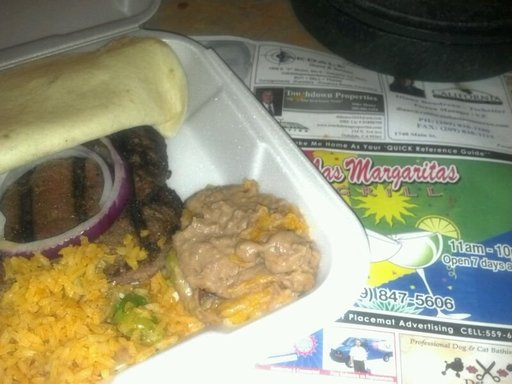

In [9]:
import numpy as np
import matplotlib.pyplot as plt

img_as_arr = np.array(img)
img_as_arr

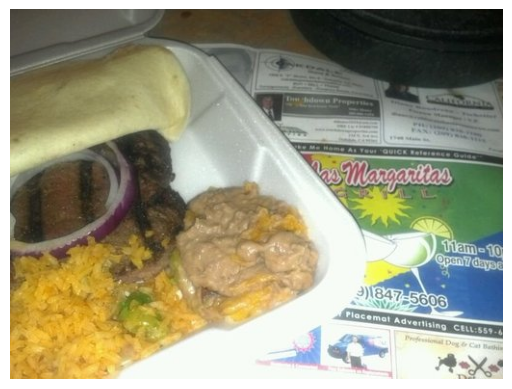

In [10]:
plt.Figure(figsize=(10,7))
plt.imshow(img_as_arr)
plt.axis(False)
plt.show()

# Transform Data

Before we can use our image data with PyTorch we need to:

- Turn it into tensors (numerical representations of our images).
- Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

In [11]:
type(img),type(random_image)

(PIL.JpegImagePlugin.JpegImageFile, pathlib.PosixPath)

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

## Transforming data with torchvision.transforms

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation

transform steps:
1. Resize the images using transforms.Resize()
2. Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor().

In [13]:
# tranform image
data_transform = transforms.Compose(
    [
        transforms.Resize(size=(64,64)), # resize image to 64x64
        transforms.RandomHorizontalFlip(p=0.5), # randomly flip image horizontally with 50% probability
        transforms.ToTensor() # convert image to tensor
	 ]
)

In [14]:
def plot_transform_img(image_paths, transform, n= 3):
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].axis(False)
            ax[0].set_title("Original Image")
            transformed_img = transform(f).permute(1, 2, 0) # permute the image to (C,H,W) format
            ax[1].imshow(transformed_img)
            ax[1].axis(False)
            fig.suptitle(f"Transformed Image: {image_path.stem}")
            plt.show()

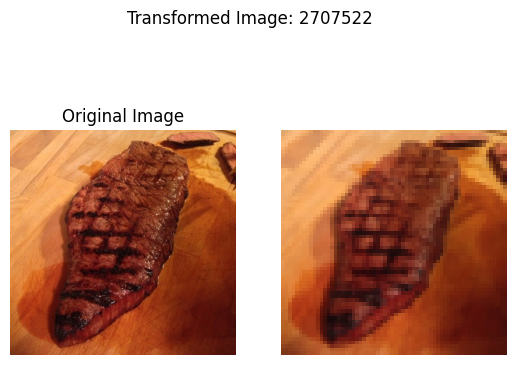

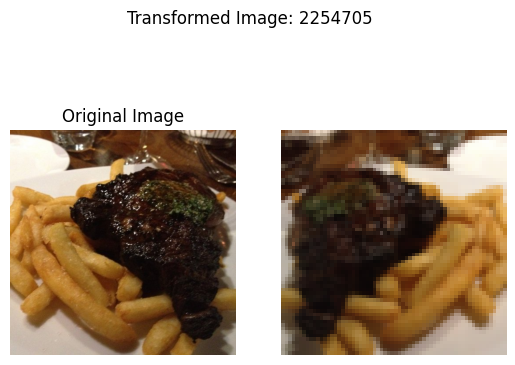

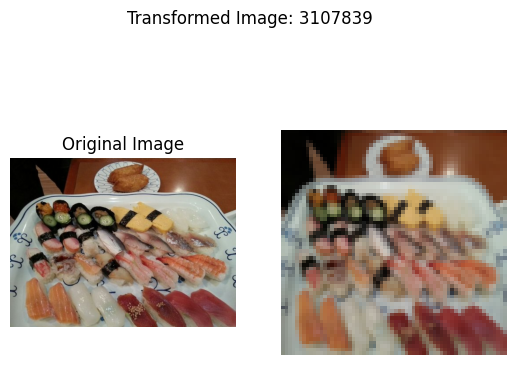

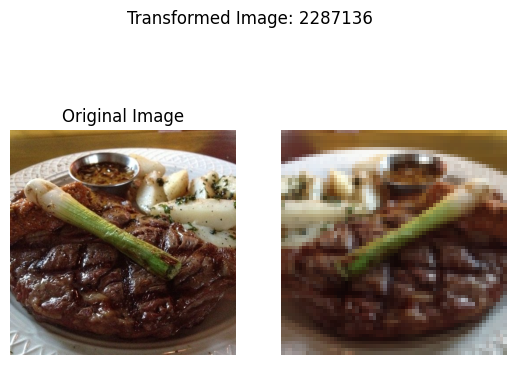

In [15]:
plot_transform_img(image_path_list, data_transform, n=4)

# Option1: Load Image

##  Loading Image Data Using ImageFolder

Alright, time to turn our image data into a Dataset capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders train_dir and test_dir passing in transform=data_transform to turn our images into tensors.

In [16]:
# use ImageFolder to load the data
from torchvision.datasets import ImageFolder

train_data = ImageFolder(
    root=train_dir, # path to training data
    transform=data_transform, # tranform to apply to the training data
    target_transform=None # tranform to apply to the target labels (not used here)
)
test_data = ImageFolder(
    root=test_dir , # path to test data
    transform=data_transform, # tranform to apply to the test data
)

In [17]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: dataset/food_dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: dataset/food_dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [18]:
# get class name as list
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [19]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data[0][1]

0

In [22]:
img = train_data[0][0] # get the first image from the training data
label = train_data[0][1] # get the first label from the training data

print(f"Image shape: {img.shape} \nLabel: {label}")
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"label class: {class_name[label]}")

Image shape: torch.Size([3, 64, 64]) 
Label: 0
Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902

How about we plot a single image tensor using matplotlib?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).

In [23]:
img_premute = img.permute(1,2,0)
print(f'Original image shape: {img.shape} ->[C,H,W]')
print(f'Permuted image shape: {img_premute.shape} ->[H,W,C]')

Original image shape: torch.Size([3, 64, 64]) ->[C,H,W]
Permuted image shape: torch.Size([64, 64, 3]) ->[H,W,C]


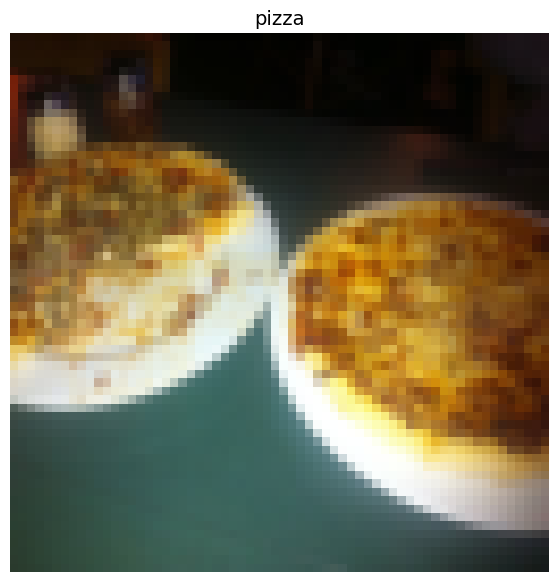

In [24]:
# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_name[label], fontsize=14);

## Turn loaded images into DataLoader's

Turning our Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets

In [25]:
os.cpu_count()

2

In [ ]:
# Turn data into DataLoader
train_dataloader = DataLoader(
    dataset=train_data, # training data
    batch_size=1 ,# number of samples per batch (1 for now)
    num_workers=1, # number of subprocesses to use for data loading (1 for now)
	 shuffle=True, # shuffle the data at every epoch (True for now)
)

test_dataloader = DataLoader(
	 dataset=test_data, # test data
	 batch_size=1, # number of samples per batch (1 for now)
	 num_workers=1, # number of subprocesses to use for data loading (1 for now)
	 shuffle=False # shuffle the data at every epoch (False for now)
)

# Check the length of the dataloaders
len(train_dataloader), len(test_dataloader)

(225, 75)

In [27]:
image ,label = next(iter(train_dataloader)) # get the first batch of data from the training dataloader
print(f"Image shape: {image.shape} \nLabel: {label}")
print(f"Image shape: {image.shape} [batch_size, channels, height, width]")

Image shape: torch.Size([1, 3, 64, 64]) 
Label: tensor([2])
Image shape: torch.Size([1, 3, 64, 64]) [batch_size, channels, height, width]


# Option 2: Load Image

## Custom Dataset

What if a pre-built Dataset creator like torchvision.datasets.ImageFolder() didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

Pros:
- Can create a Dataset out of almost anything.
- Not limited to PyTorch pre-built Dataset functions.

Cons:
- Even though you could create a Dataset out of almost anything, it doesn't mean it will work.
- Using a custom Dataset often results in writing more code, which could be prone to errors or performance issues.

In [28]:
import os
from pathlib import Path
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict

In [29]:
train_data.classes , train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [30]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: dataset/food_dataset/train
Class names found: ['pizza', 'steak', 'sushi']


In [31]:
# Creating a helper function to get class names
def find_classes(dir):
    classes = sorted(entry.name for entry in list(os.scandir(dir)) if entry.is_dir())
    if not classes:
      raise FileNotFoundError(f"No classes found in {dir}.")
    class_to_idx = {cls_name :i for i,cls_name in enumerate(classes)}
    return classes, class_to_idx

In [32]:
fiding_classes = find_classes(train_dir)
print(f"Classes found: {fiding_classes[1]}")

Classes found: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [33]:
# Write a custom dataset class

class CustomImageFolder(Dataset):
    def __init__(self,target_dir,transforms= None):
        # get all image paths
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        # stup tansform
        self.transform = transforms
        # get class names and class to index mapping
        self.classes ,self.class_to_idx = find_classes(target_dir)

    # make function load images
    def load_images(self,index):
      image_path = self.paths[index]
      return Image.open(image_path)

    # override __len__ method
    def __len__(self):
         return len(self.paths)
    # override __getitem__ method
    def __getitem__(self, index):
        img = self.load_images(index)
        class_name =self.paths[index].parent.stem # get the class name from the image path
        label = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img) ,label
        else:
            return img ,label

In [34]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [35]:
train_data_custom = CustomImageFolder(target_dir=train_dir,
                                      transforms=train_transforms)
test_data_custom = CustomImageFolder(target_dir=test_dir,
                                     transforms=test_transforms)
train_data_custom, test_data_custom

(<__main__.CustomImageFolder at 0x7b1f95f24850>,
 <__main__.CustomImageFolder at 0x7b1e70546290>)

In [36]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [37]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [38]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [39]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [40]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

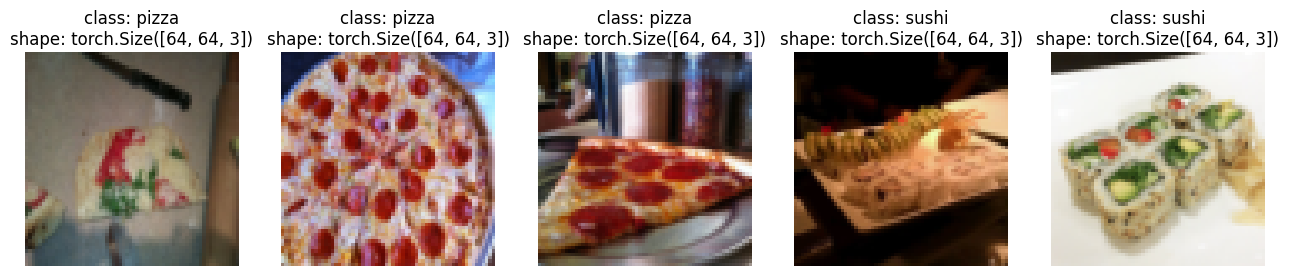

In [41]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_name,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


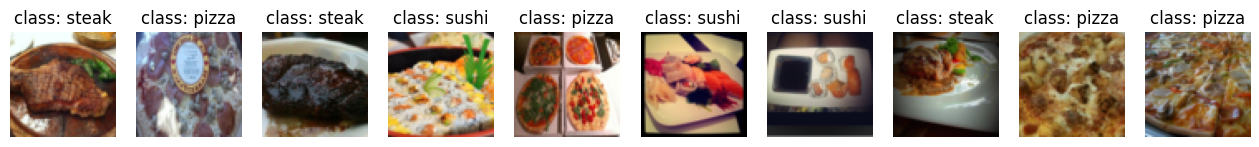

In [42]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_name,
                      seed=None) # Try setting the seed for reproducible images

## Turn custom loaded images into DataLoader's

In [43]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, #samples per batch (1 for now)
                                     num_workers=0, # how many subprocesses to use for data loading (0 for now)
                                     shuffle=True) # shuffle the data

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, # samples per batch (1 for now)
                                    num_workers=0, #
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7b1e6fe9af50>,
 <torch.utils.data.dataloader.DataLoader at 0x7b1e703f7490>)

In [44]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Other forms of transforms (data augmentation)
We've seen a couple of transforms on our data already but there's plenty more.
The purpose of tranforms is to alter your images in some way.
That may be turning your images into a tensor.
Or cropping it or randomly erasing a portion or randomly rotating them.

Doing these kinds of transforms is often referred to as data augmentation.


In [45]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

**Note**: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

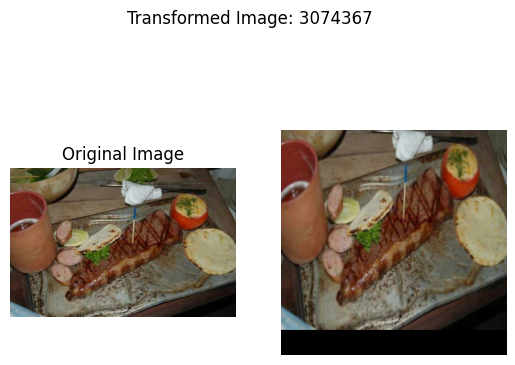

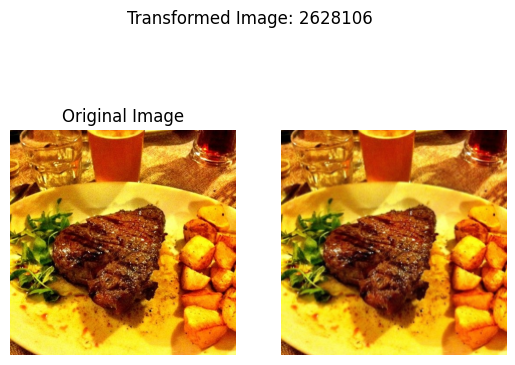

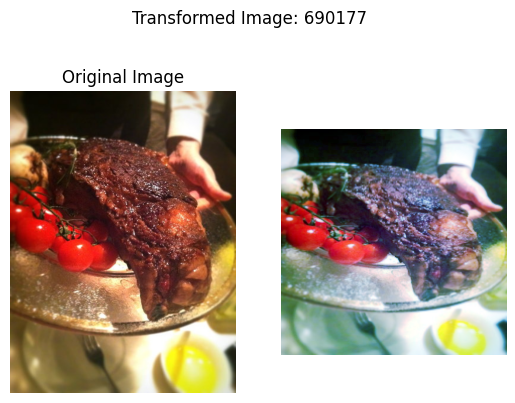

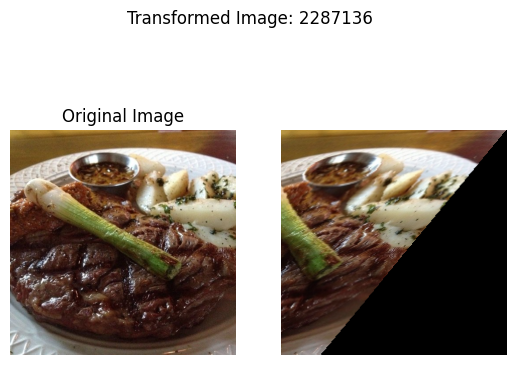

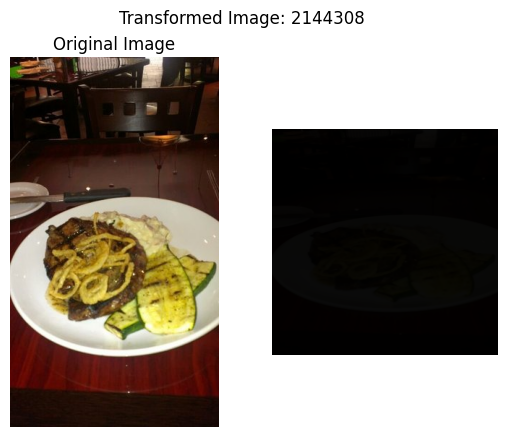

In [46]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transform_img(
    image_path_list,
	 transform=train_transforms,
	 n=5
)

# Model V1 : TinyVGG without data augmentation

Alright, we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to (64, 64) and turning them into tensors.

## Creating transforms and loading data for Model V1

In [47]:
# create sample transform
sample_transform = transforms.Compose(
    [
        transforms.Resize(size=(64,64)),
        transforms.ToTensor()
	 ]
)

In [48]:
# load and Transform dataset
train_data_sample = datasets.ImageFolder(
    root=train_dir,
    transform=sample_transform, # tranform to apply to the training data
	 target_transform=None # tranform to apply to the target labels (not used here)
)

test_data_sample = datasets.ImageFolder(
    root=test_dir , # path to test data
	 transform=sample_transform, # tranform to apply to the test data
)

In [49]:
# setup batch_size = 32
num_workers = os.cpu_count()
batch_size = 32


In [50]:
# create DataLoader for training and test data
train_dataloader_sample = DataLoader(
    train_data_sample, # training data
	 batch_size=batch_size, # number of samples per batch (32 for now)
	 num_workers=num_workers, # number of subprocesses to use for data loading (1 for now)
	 shuffle=True, # shuffle the data at every epoch (True for now)
)

test_dataloader_sample = DataLoader(
    test_data_sample, # test data
    batch_size=batch_size, # number of samples per batch (32 for now)
    shuffle=False, # shuffle the data at every epoch (False for now)
    num_workers=num_workers # number of subprocesses to use for data loading (1 for now)
)

##  TinyVGG model V1

In [51]:
import torch
from torch import nn

class TinyVggV1(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 16 * 16, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.fc_layer(x)
        return x


In [52]:
model_v1= TinyVggV1(
    input_shape =3, # color channels (RGB)
    hidden_units = 10, # number of hidden units in the hidden layer
	 output_shape = len(train_data_sample.classes) # number of classes (3 for pizza, steak, sushi)
)

In [53]:
pip install torchinfo

In [54]:
from torchinfo import summary

summary(
    model_v1,
    input_size = [1,3,64,64], # [batch_size, color_channels, height, width
)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVggV1                                [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Train & Test loop functions

In [61]:
def train(
    model: nn.Module,
    dataloader : DataLoader,
    loss_fn : nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device):

  # put model into train mode
  model.train()

  # setup train loss and accuracy
  total_loss, total_accuracy =0 , 0

  #  traning loop
  for batch , (x,y) in enumerate(dataloader):

    # x, y to device
    x ,y = x.to(device), y.to(device)

    # forward pass
    y_pred = model(x)

    # calculate loss
    loss = loss_fn(y_pred, y)
    total_loss +=loss.item()

    # optimizer
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # optimizer step
    optimizer.step()

    # calculate accuracy and label
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim =1)
    total_accuracy += (y_pred_class == y).sum().item()/len(y_pred)

  # adjust metrices
  total_loss = total_loss/len(dataloader)
  total_accuracy = total_accuracy/len(dataloader)
  return total_loss , total_accuracy



In [62]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [63]:
from tqdm.auto import tqdm

def model_train(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int):

  # result dict
  result = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  # traning and testing loop for epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model=model,
                                  dataloader=train_dataloader,
                                  loss_fn=loss_fn,
                                  optimizer=optimizer,
                                  device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    print(f"Epoch: {epoch} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}")

    # update empty result dict
    result["train_loss"].append(train_loss)
    result["train_acc"].append(train_acc)
    result["test_loss"].append(test_loss)
    result["test_acc"].append(test_acc)

  return result

## Train and Evaluate

In [64]:
# num of epochs
epochs = 5

# recreate model instance
model_v1 = TinyVggV1(
    input_shape =3, # color channels (RGB)
    hidden_units = 10, # number of hidden units in the hidden layer
	 output_shape = len(train_data_sample.classes) # number of classes (3 for pizza, steak, sushi)
).to(device)

In [65]:
# setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v1.parameters(), lr=0.001)

In [66]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_v1
model_v1_results = model_train(
    model=model_v1,
    train_dataloader=train_dataloader_sample,
    test_dataloader=test_dataloader_sample,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.1228 | Train_acc: 0.2812 | Test_loss: 1.0669 | Test_acc: 0.5417
Epoch: 1 | Train_loss: 1.1041 | Train_acc: 0.2578 | Test_loss: 1.1076 | Test_acc: 0.2604
Epoch: 2 | Train_loss: 1.0872 | Train_acc: 0.5234 | Test_loss: 1.1361 | Test_acc: 0.1979
Epoch: 3 | Train_loss: 1.1021 | Train_acc: 0.2930 | Test_loss: 1.1542 | Test_acc: 0.1979
Epoch: 4 | Train_loss: 1.0919 | Train_acc: 0.2930 | Test_loss: 1.1600 | Test_acc: 0.2604
Total training time: 5.241 seconds


##  Plot the loss

In [67]:
model_v1_results

{'train_loss': [1.1228010207414627,
  1.10406394302845,
  1.0871904790401459,
  1.1020928621292114,
  1.0918839573860168],
 'train_acc': [0.28125, 0.2578125, 0.5234375, 0.29296875, 0.29296875],
 'test_loss': [1.0669073065121968,
  1.1076006094614665,
  1.1361066500345867,
  1.154240886370341,
  1.1600202322006226],
 'test_acc': [0.5416666666666666,
  0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.2604166666666667]}

In [68]:
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

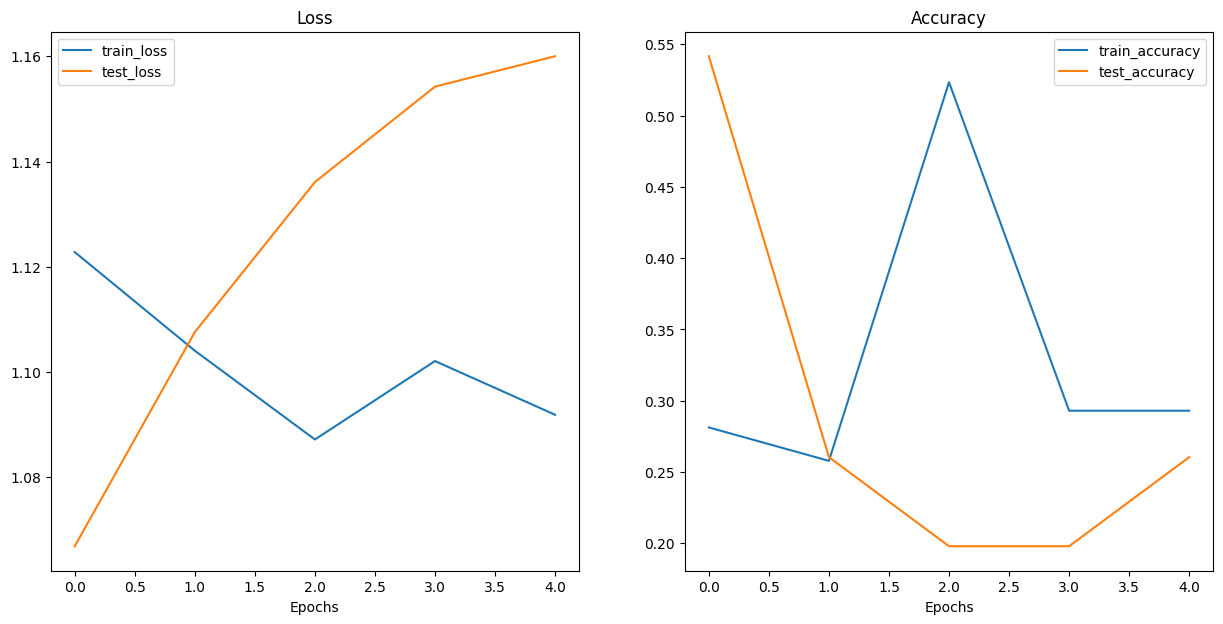

In [69]:
plot_loss_curves(model_v1_results)

Looking at training and test loss curves is a great way to see if your model is overfitting.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is overfitting.

In [85]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_v1 with higher no of epochs
model_v1_results_50_epochs = model_train(
    model=model_v1,
    train_dataloader=train_dataloader_sample,
    test_dataloader=test_dataloader_sample,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.0857 | Train_acc: 0.4336 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 1 | Train_loss: 1.0872 | Train_acc: 0.3125 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 2 | Train_loss: 1.0849 | Train_acc: 0.4336 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 3 | Train_loss: 1.0847 | Train_acc: 0.4336 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 4 | Train_loss: 1.1131 | Train_acc: 0.3125 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 5 | Train_loss: 1.1211 | Train_acc: 0.3125 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 6 | Train_loss: 1.0919 | Train_acc: 0.3125 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 7 | Train_loss: 1.0828 | Train_acc: 0.4336 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 8 | Train_loss: 1.0816 | Train_acc: 0.4336 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 9 | Train_loss: 1.1145 | Train_acc: 0.3125 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 10 | Train_loss: 1.0859 | Train_acc: 0.4336 | Test_loss: 1.1600 | Test_acc: 0.2604
Epoch: 11 | Train_lo

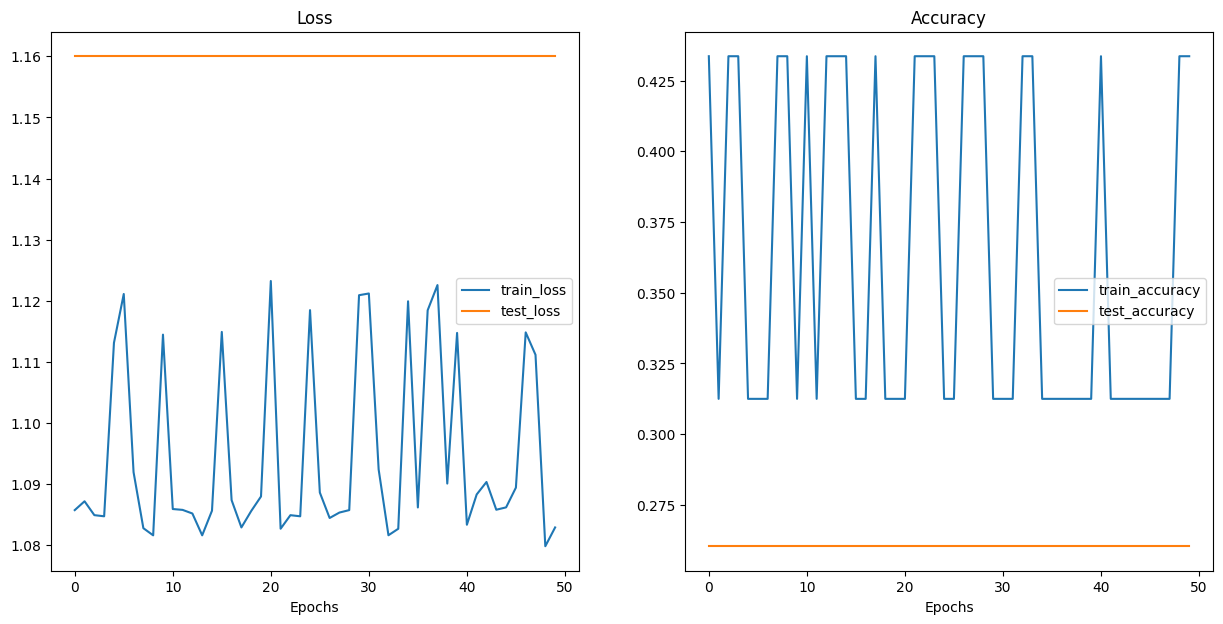

In [86]:
plot_loss_curves(model_v1_results_50_epochs)

# Model v2: TinyVGG with Data Augmentation

## Transform with data augmentation

In [71]:
# create traning transform data with TrivialAugment
train_data_aug = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor()
    ]
)

test_data_aug = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.ToTensor()
    ]
)

## train and test Dataset's and DataLoader's

In [72]:
train_data_augmented = ImageFolder(
    root=train_dir,
    transform=train_data_aug,
    target_transform=None
)

test_data_augmented = ImageFolder(
    root=test_dir,
    transform=test_data_aug,
    target_transform=None
)

In [73]:
train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: dataset/food_dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: dataset/food_dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [75]:
batch_size = 32
num_workers = os.cpu_count()

train_dataloader_augmented = DataLoader(
    train_data_augmented,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
)

test_dataloader_augmented = DataLoader(
    test_data_augmented,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)
print(num_workers)

2


## Construct and train Model v2

In [76]:
Model_v2 = TinyVggV1(
    input_shape =3, # color channels (RGB)
    hidden_units = 10, # number of hidden units in the hidden layer
	 output_shape = len(train_data_augmented.classes) # number of classes (3 for pizza, steak, sushi)
)

In [77]:
summary(
    Model_v2,
    input_size = [1,3,64,64], # [batch_size, color_channels, height, width
)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVggV1                                [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [79]:
epochs = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=Model_v2.parameters(), lr=0.001)

In [87]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_v2_results = model_train(
    model=Model_v2,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_augmented,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 0.8769 | Train_acc: 0.6367 | Test_loss: 0.9292 | Test_acc: 0.5436
Epoch: 1 | Train_loss: 0.8104 | Train_acc: 0.6680 | Test_loss: 0.9535 | Test_acc: 0.4924
Epoch: 2 | Train_loss: 0.9030 | Train_acc: 0.5000 | Test_loss: 1.0227 | Test_acc: 0.4517
Epoch: 3 | Train_loss: 1.0610 | Train_acc: 0.4375 | Test_loss: 1.2413 | Test_acc: 0.4025
Epoch: 4 | Train_loss: 0.7984 | Train_acc: 0.6445 | Test_loss: 1.1016 | Test_acc: 0.3939
Total training time: 6.290 seconds


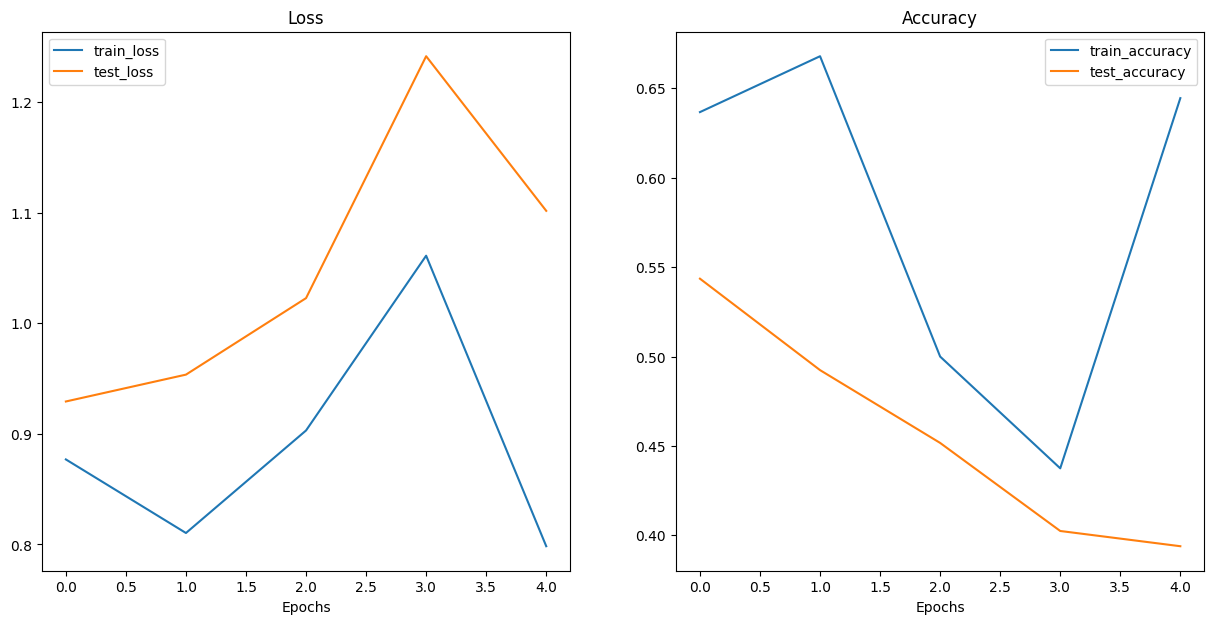

In [88]:
plot_loss_curves(model_v2_results)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 0.9501 | Train_acc: 0.4883 | Test_loss: 1.1164 | Test_acc: 0.3627
Epoch: 1 | Train_loss: 0.8669 | Train_acc: 0.6562 | Test_loss: 1.1092 | Test_acc: 0.3324
Epoch: 2 | Train_loss: 0.7649 | Train_acc: 0.6641 | Test_loss: 1.1306 | Test_acc: 0.3835
Epoch: 3 | Train_loss: 0.9596 | Train_acc: 0.4766 | Test_loss: 1.0868 | Test_acc: 0.4138
Epoch: 4 | Train_loss: 0.9208 | Train_acc: 0.5156 | Test_loss: 1.0188 | Test_acc: 0.4441
Epoch: 5 | Train_loss: 0.8315 | Train_acc: 0.6641 | Test_loss: 1.1652 | Test_acc: 0.4328
Epoch: 6 | Train_loss: 0.9232 | Train_acc: 0.5234 | Test_loss: 1.0453 | Test_acc: 0.4441
Epoch: 7 | Train_loss: 0.8402 | Train_acc: 0.6250 | Test_loss: 1.0108 | Test_acc: 0.4545
Epoch: 8 | Train_loss: 0.7806 | Train_acc: 0.6445 | Test_loss: 1.0325 | Test_acc: 0.4337
Epoch: 9 | Train_loss: 0.7794 | Train_acc: 0.6758 | Test_loss: 1.0394 | Test_acc: 0.4735
Epoch: 10 | Train_loss: 0.8274 | Train_acc: 0.5820 | Test_loss: 1.0630 | Test_acc: 0.4441
Epoch: 11 | Train_lo

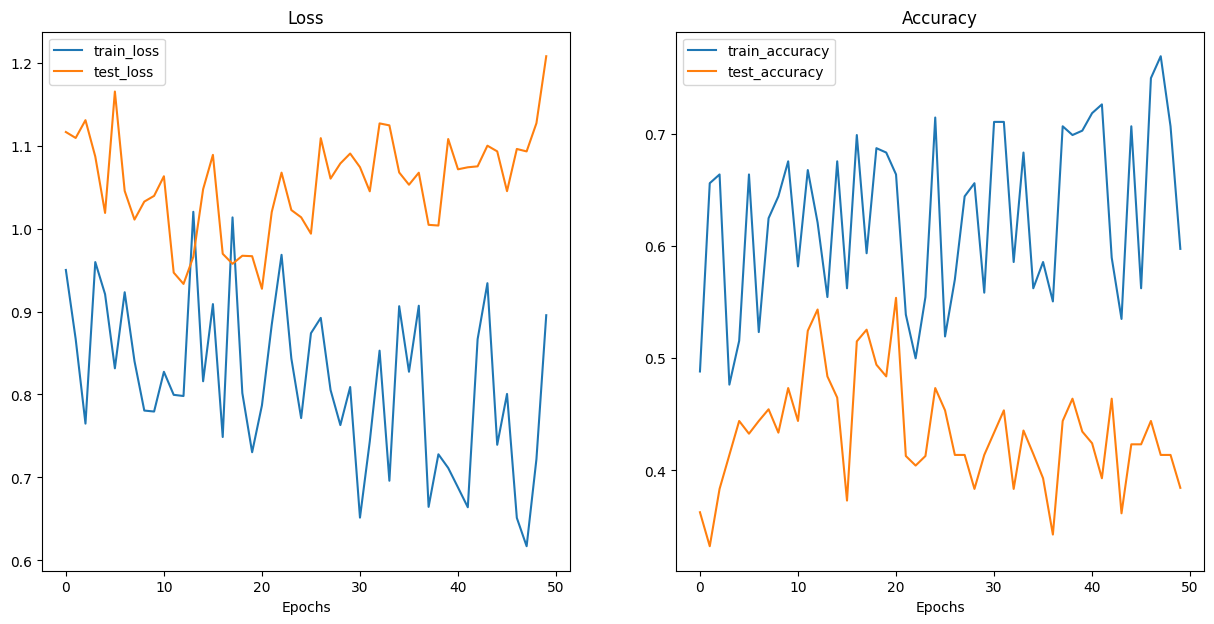

In [89]:
 # Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_v2 higher no of epochs
model_v2_results_epoch_50 = model_train(
    model=Model_v2,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_augmented,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model_v2_results_epoch_50)


# Compare model results

In [90]:
import pandas as pd
model_v1_df = pd.DataFrame(model_v1_results)
model_v2_df = pd.DataFrame(model_v2_results)

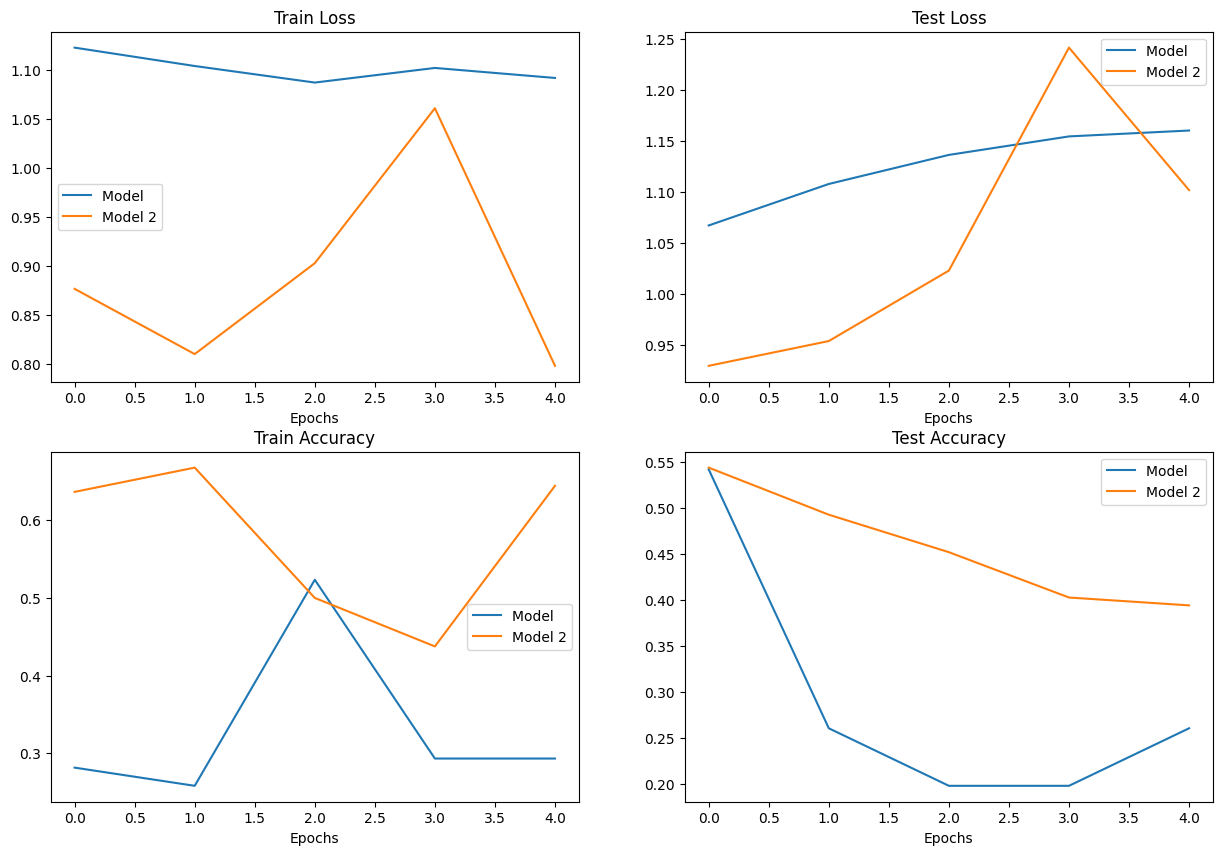

In [92]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_v1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_v1_df["train_loss"], label="Model ")
plt.plot(epochs, model_v2_df["train_loss"], label="Model 2")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_v1_df["test_loss"], label="Model ")
plt.plot(epochs, model_v2_df["test_loss"], label="Model 2")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_v1_df["train_acc"], label="Model ")
plt.plot(epochs, model_v2_df["train_acc"], label="Model 2")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_v1_df["test_acc"], label="Model ")
plt.plot(epochs, model_v2_df["test_acc"], label="Model 2")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Make a prediction on a custom image

In [93]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

##  Loading in a custom image with PyTorch

In [94]:
from torchvision.io import read_image

# read_custom image
custom_image = read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

Our custom_image tensor is of datatype torch.uint8 and its values are between [0, 255].

But our model takes image tensors of datatype torch.float32 and with values between [0, 1].

So before we use our custom image with our model, we'll need to convert it to the same format as the data our model is trained on.

If we don't do this, our model will error.

In [98]:
# Try to make a prediction on image in uint8 format (this will error)
Model_v2.eval()
with torch.inference_mode():
    Model_v2(custom_image.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [99]:
# Load in custom image and convert the tensor values to float32
custom_image = read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

## Predicting on custom images with a trained PyTorch model

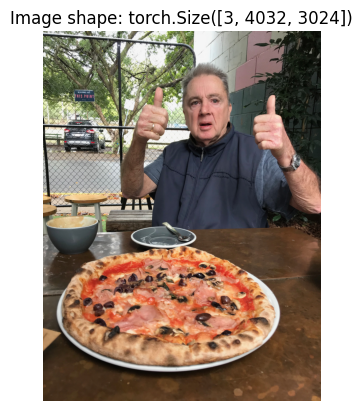

In [100]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [101]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [102]:
Model_v2.eval()
with torch.inference_mode():
    custom_image_pred = Model_v2(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

Despite our preparations our custom image and model are on different devices.

In [103]:
Model_v2.eval()
with torch.inference_mode():
    custom_image_pred = Model_v2(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x10)

There's one dimension we forgot about.

The batch size.

Our model expects image tensors with a batch size dimension at the start (NCHW where N is the batch size).

Except our custom image is currently only CHW.

In [104]:
Model_v2.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = Model_v2(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [105]:
custom_image_pred

tensor([[2.2169, 0.8666, 1.1124]], device='cuda:0')

Let's convert them from logits -> prediction probabilities -> prediction labels.



In [106]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[2.2169, 0.8666, 1.1124]], device='cuda:0')
Prediction probabilities: tensor([[0.6287, 0.1629, 0.2083]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [108]:
# Find the predicted label
custom_image_pred_class = class_name[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [109]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

    # 1. Load in image and convert the tensor values to float32
    target_image =read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

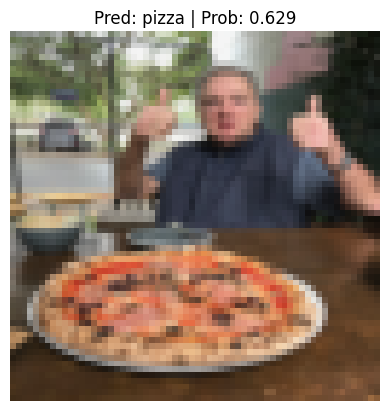

In [111]:
# Pred on our custom image
pred_and_plot_image(model=Model_v2,
                    image_path=custom_image_path,
                    class_names=class_name,
                    transform=custom_image_transform,
                    device=device)